<a href="https://colab.research.google.com/github/dosepix/DosepixCalibration/blob/main/DNN_calibration_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import dill
import tqdm

from keras import backend as K
from keras.layers import Input, Dense, Conv1D, Flatten, Reshape, AveragePooling1D, Lambda, Multiply, Add, Dropout, Concatenate, GaussianNoise
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.utils import plot_model
from keras.backend import mean
from keras.optimizers import Adam
from keras import losses, metrics, regularizers
import keras.callbacks
import tensorflow as tf

from IPython.display import Image
from IPython.core.display import HTML
import json

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os, sys
directory = '/content/gdrive/My Drive/Colab Notebooks/calib_data/'
sys.path.insert(0, directory)

In [ ]:
SIMPLE = False
def energyToToTSimple(x, a, b, c, t):
    if SIMPLE:
        thl = getTHL(a, b, c, t)
        res = np.where(x > thl, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
        # res = np.where(x > thl, a*x - c * (np.pi / 2 + t / (x - b)), 0)
        return res
    else:
	      return np.where(x >= getTHL(a, b, c, t), a*x + b + float(c)/(x - t), 0)

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    if SIMPLE:
        return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k
    else:
      	return 1./(2*a) * ( t*a + x - b + np.sqrt((b + t*a - x)**2 - 4*a*c) )

def getTHL(a, b, c, t):
    if SIMPLE:
        return (4*a*b + np.sqrt(c * (16 * a * t + np.pi**2 * c)) + np.pi * c) / (4 * a)
    else:
        return 1./(2*a) * ( t*a - b + np.sqrt((b + t*a)**2 - 4*a*c) )

def get_t(THL, a, b, c):
    return (2*a*b**2 - 4*a*b*THL + 2*a*THL**2 + np.pi*b*c - np.pi*c*THL)/(2*c)

def expDecay(x, A, k, c):
    return A * np.exp(-k * x) + c

def smearSpectrumFunction(data, sigmaParams):
    data = np.asarray( data )
    sigma = np.abs(expDecay(data, *sigmaParams))
    data_smear = np.random.normal(data, scale=sigma)
    return data_smear

def getColor(c, N, idx):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap(c)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

### Loading of training and evaluation dataset

In [ ]:
def load_json(fn):
    with open(fn, 'r') as f:
        d = json.load(f)
    return np.asarray(d['x']), np.asarray(d['y'])

In [ ]:
if SIMPLE:
    p_norm = [2.5, 8.5, -55, -1.75]
else:
    p_norm = [0.4, 100.0, -275.0, 7.5] 

p_norm = [2.15, 150.0, -275.0, 7.5]

#### Load

In [ ]:
x_train_list, y_train_list = [], []
for fn in ['train_small_newCalFunc.json']:
    x_train, y_train = load_json(directory + fn)
    x_train_list += list(x_train)
    y_train_list += list(y_train)
x_train, y_train = np.asarray(x_train_list), np.asarray(y_train_list)

In [ ]:
x_eval_list, y_eval_list = [], []
for fn in ['eval_small_newCalFunc.json']:
    x_eval, y_eval = load_json(directory + fn)
    x_eval_list += list(x_eval)
    y_eval_list += list(y_eval)
x_eval, y_eval = np.asarray(x_eval_list), np.asarray(y_eval_list)

## Estimate peak positions in ToT via fit

In [ ]:
import scipy.optimize
def normal(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

def normal(x, mu, sigma, A, off):
	return A * np.exp(-(x - mu)**2/(2*sigma**2)) + off

# Erf-function is used to model the background
def normalShift(a, b, mu, sigma):
	return np.sqrt(2./np.pi)*float(b)/a*sigma

def normalBack(x, mu, sigma, a, b):
	return b * scipy.special.erf((x+normalShift(a, b, mu, sigma) - mu) / (np.sqrt(2) * sigma)) + abs(b)

def normalTotal(x, mu, sigma, a, b, c):
	return normal(x+normalShift(a, b, mu, sigma), mu, sigma, a, c) + normalBack(x, mu, sigma, a, b)

def getPeakPositions(x, plot=False):
    bins = np.arange(len(x))
    thl = int(0.9 * len(x[x > 0]))
    if plot:
        plt.plot(x)
        plt.axvline(x=thl, ls='--', color='k')

    # Left
    x_max = np.argmax(x[:thl])
    x_filt = x[x_max - 20: x_max + 20]
    x_filt /= np.max(x_filt)
    bins_filt =  bins[x_max - 20: x_max + 20]

    p0 = (bins[x_max], 30, .1, .1, .1)
    try:
        popt, pcov = scipy.optimize.curve_fit(normalTotal, bins_filt, x_filt, p0=p0)
    except:
        popt = p0
    peakLeft = popt[0]
    if plot:
        plt.plot(bins_filt, x_filt)
        plt.plot(bins_filt, normalTotal(bins_filt, *popt))

    # Right
    x_max = np.argmax(x[thl:])
    x_filt = x[thl + x_max - 20: thl + x_max + 30]
    x_filt /= np.max(x_filt)
    bins_filt = bins[thl + x_max - 20: thl + x_max + 30]

    # p0 = (bins[thl:][0] + bins[x_max], 30)
    p0 = (bins[thl:][0] + bins[x_max], 30, .1, .1, .1)
    try:
        popt, pcov = scipy.optimize.curve_fit(normalTotal, bins_filt, x_filt, p0=p0)
    except:
        pass

    peakRight = popt[0]
    if plot:
        plt.plot(bins_filt, x_filt)
        plt.plot(bins_filt, normalTotal(bins_filt, *popt))
        plt.plot(x_max + thl, x[x_max + thl], ls='', marker='x')
    return peakLeft, peakRight

196.62145793763693 327.68073357496286
13.701555928134317
58.13302790606848


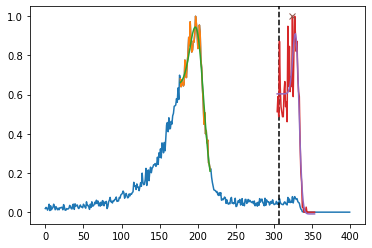

In [ ]:
idx = np.random.randint(1000)
p1, p2 = getPeakPositions(np.asarray(x_train[idx]).flatten(), plot=True)
print(p1, p2)
print(ToTtoEnergySimple(p1, *y_train[idx] * p_norm))
print(ToTtoEnergySimple(p2, *y_train[idx] * p_norm))

In [ ]:
peaksTrain = []
idx_fail = []
for idx, x in enumerate( tqdm.tqdm(x_train) ):
    try:
        p1, p2 = getPeakPositions(x.flatten())
        p1_ = ToTtoEnergySimple(p1, *y_train[idx] * p_norm)
        p2_ = ToTtoEnergySimple(p2, *y_train[idx] * p_norm)
        if (np.abs(p1_ - 16) > 5) or (np.abs(p2_ - 57.8) > 5):
            plt.plot(x.flatten())
            idx_fail.append( idx )
            peaksTrain.append( [0, 0] )
        else:
            peaksTrain.append( [p1, p2] )
    except:
        plt.plot(x.flatten())
        idx_fail.append( idx )
        peaksTrain.append( [0, 0] )
peaksTrain = np.asarray(peaksTrain)
idx_fail = np.asarray( idx_fail )

# Remove failed events from data
x_train = np.delete(x_train, idx_fail, axis=0)
y_train = np.delete(y_train, idx_fail, axis=0)
peaksTrain = np.delete(peaksTrain, idx_fail, axis=0)

In [ ]:
peaksEval = []
idx_fail = []
for idx, x in enumerate( tqdm.tqdm(x_eval) ):
    try:
        p1, p2 = getPeakPositions(x.flatten())
        p1_ = ToTtoEnergySimple(p1, *y_eval[idx] * p_norm)
        p2_ = ToTtoEnergySimple(p2, *y_eval[idx] * p_norm)
        if (np.abs(p1_ - 16) > 5) or (np.abs(p2_ - 57.8) > 5):
            plt.plot(x.flatten())
            idx_fail.append( idx )
            peaksEval.append( [0, 0] )
        else:
            peaksEval.append( [p1, p2] )
    except:
        plt.plot(x.flatten())
        idx_fail.append( idx )
        peaksEval.append( [0, 0] )
peaksEval = np.asarray(peaksEval)
idx_fail = np.asarray( idx_fail )

# Remove failed events from data
x_eval = np.delete(x_eval, idx_fail, axis=0)
y_eval = np.delete(y_eval, idx_fail, axis=0)
peaksEval = np.delete(peaksEval, idx_fail, axis=0)

In [ ]:
train_filt = ((y_train * p_norm)[:,0] > 1.) # & ((y_train * p_norm)[:,1] > 100)
eval_filt = ((y_eval * p_norm)[:,0] > 1.) # & ((y_eval * p_norm)[:,1] > 100)

x_train = x_train[train_filt]
y_train = y_train[train_filt]
x_eval = x_eval[eval_filt]
y_eval = y_eval[eval_filt]
peaksTrain = peaksTrain[train_filt]
peaksEval = peaksEval[eval_filt]

In [ ]:
from keras.layers import Layer
# from keras.legacy import interfaces

class GaussianConvolutionNoise(Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianConvolutionNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            input_noise = inputs * (1 + K.random_normal(K.shape(inputs), stddev=np.random.uniform(0, self.stddev)))
            input_noise = K.switch(K.equal(inputs, 0.), K.zeros_like(inputs), input_noise)
            out = K.clip(input_noise, 0, 1 + 3 * self.stddev)
            return out
        return K.in_train_phase(noised, inputs, training=training)

    def get_config(self):
        config = super().get_config()
        config['stddev'] = self.stddev
        return config

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


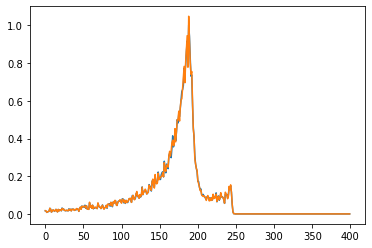

In [ ]:
x = GaussianConvolutionNoise(.5)(K.constant(x_eval[23]), training=True)
plt.plot(x_eval[23])
plt.plot(K.eval(x))

In [ ]:
activation = 'relu'
filter_size = 16
output_size = 4
kernel_size = 5

# Inputs
input_img = Input(shape=(400, 1))
input_peak = Input(shape=(2,))

# Convolution
# x = GaussianNoise(.15)(input_img)
x = GaussianConvolutionNoise(.3)(input_img)
x = Conv1D(filter_size, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)
x = Conv1D(filter_size << 1, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 1, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 1, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)
x = Conv1D(filter_size << 2, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 2, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 2, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)
x = Conv1D(filter_size << 3, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 3, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = Conv1D(filter_size << 3, kernel_size=kernel_size, activation=activation, padding='same')(x)
x = AveragePooling1D(pool_size=2, strides=2, padding='valid')(x)

# Flatten
x = Flatten()(x)

# Dense & Dropout
x = Dense(output_size * 256, activation=activation)(x)
x = Dropout(rate=0.2)(x)
x = Dense(output_size * 128, activation=activation)(x)
x = Dropout(rate=0.2)(x)
x = Dense(output_size * 64, activation=activation)(x)
x = Dropout(rate=0.2)(x)
x = Dense(output_size, activation='linear')(x)

# Create model
regressor = Model((input_img, input_peak), x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
regressor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 1)            0         
_________________________________________________________________
gaussian_convolution_noise_2 (None, 400, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 16)           96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 16)           1296      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 16)           1296      
_________________________________________________________________
average_pooling1d_1 (Average (None, 200, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 32)           2592

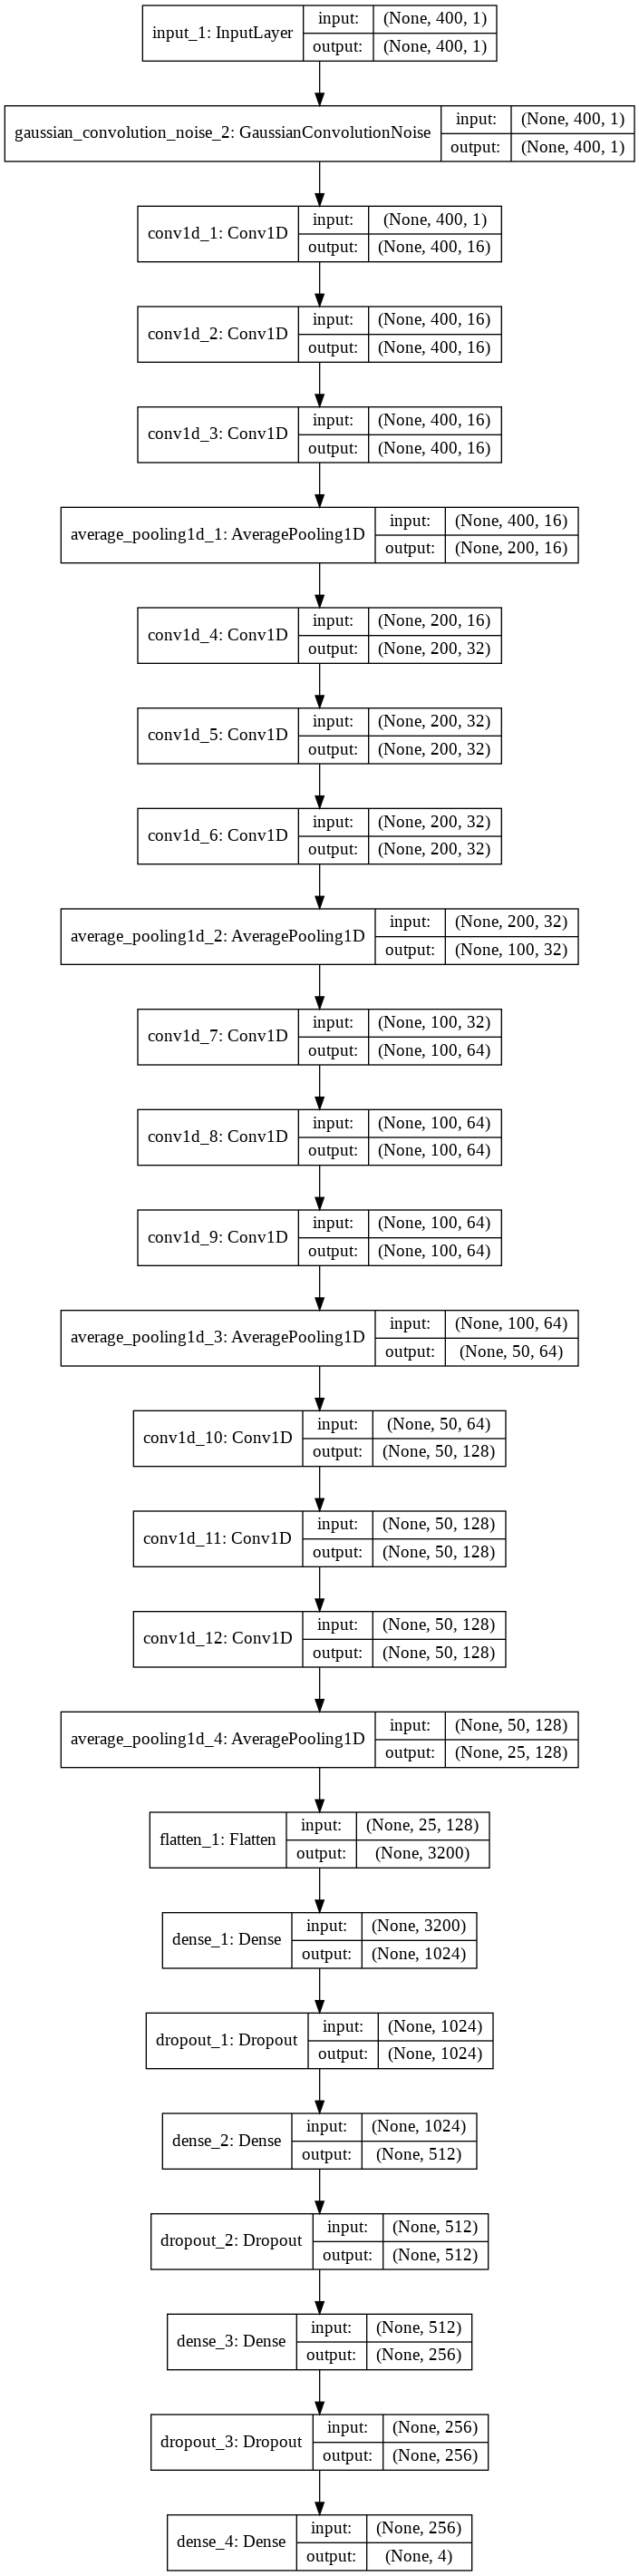

In [ ]:
PLOT_DIR = directory
plot_model(regressor, show_shapes=True, show_layer_names=True, to_file=PLOT_DIR + 'model.png')
Image(retina=False, filename=PLOT_DIR + 'model.png')

In [ ]:
adam = Adam(lr=0.0002)

def energyToToTInt(x, a, b, c, t):
    # Calculate integral
    return .5 * (a * x * (x - 2 * b) - 2 * c * t * K.log(K.abs(x - b)) - np.pi * c * x)

def ToTtoEnergySimple_keras(x, a, b, c, t):
    if SIMPLE:
        return b + 1./(4 * a) * (2*x + np.pi*c + K.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))
        # return 1./(4 * a) * (2*x + np.pi*c + 2*a*b + K.sqrt(16*a*c*t + (2*x + np.pi*c)**2 - 4*a*b*(np.pi*c - a*b + 2*x)))
    else:
        return 1./(2*a) * ( t*a + x - b + K.sqrt((b + t*a - x)**2 - 4*a*c) )

def getTHL_K(a, b, c, t):
    return (4*a*b + K.sqrt(K.abs(c * (16 * a * t + np.pi**2 * c))) + np.pi * c) / (4 * a)

def calibrationCurveLoss(yTrue, yPred):
    a, b, c, t = [yTrue[:, idx] for idx in range(4)]
    intTrue = energyToToTInt(60, a, b, c, t) - energyToToTInt(getTHL_K(a, b, c, t), a, b, c, t)

    a_, b_, c_, t_ = [yPred[:, idx] for idx in range(4)]
    intPred = energyToToTInt(60, a_, b_, c_, t_) - energyToToTInt(getTHL_K(a_, b_, c_, t_), a_, b_, c_, t_)

    paramLoss = K.sqrt(K.sum(K.square(yTrue - yPred))) 
    curveLoss = K.sqrt(K.sum(K.square(intTrue - intPred)))
    return paramLoss + curveLoss

def peakPositionLoss(peakPositions):
    def loss(yTrue, yPred):
        mse_loss = K.mean(K.abs(yPred - yTrue), axis=-1)
        # peak_loss = ToTtoEnergySimple(peakPositions)

        a, b, c, t = [yPred[:, idx] for idx in range(4)]
        a *= p_norm[0]
        b *= p_norm[1]
        c *= p_norm[2]
        t *= p_norm[3]

        peak1, peak2 = peakPositions[:,0], peakPositions[:,1]
        energy1 = ToTtoEnergySimple_keras(peak1, a, b, c, t)
        energy2 = ToTtoEnergySimple_keras(peak2, a, b, c, t)

        peak_loss = K.mean(K.sqrt(K.square(energy1 - 16.04) + K.square(energy2 - 57.8)))
        # peak_loss = K.mean( K.abs(energy1 - 16.04) )
        # peak_loss += K.mean( K.abs(energy2 - 57.8) )

        return mse_loss + 5 * peak_loss # / 10.
    return loss

# loss = 'mse'
loss = peakPositionLoss(input_peak)
regressor.compile(optimizer=adam, loss=loss, metrics=['mae', 'acc'])

In [ ]:
ToTtoEnergySimple(250, *p_norm)

49.55318086699487

In [ ]:
p1 = K.constant([[2.5, -1.6, -91., -14.5], [1.8, -1.7, -55., -12.5]])
p2 = K.constant([[1.8, -1.7, -55., -12.5], [1.8, -1.7, -55., -12.5]])
peaks = K.constant([[100, 100], [200, 200]])
loss = peakPositionLoss(peaks)(p1, p2)
K.eval(loss)

array([80.91583 , 71.215836], dtype=float32)

(array([1.27110237, 0.83286792, 0.5009518 , 1.26711595]),
 array([117.01168818, 201.88286107]))

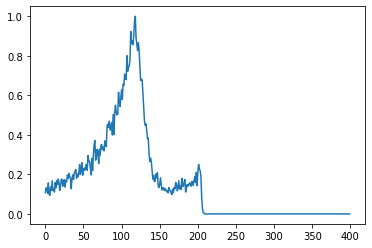

In [ ]:
plt.plot(x_train[10].flatten())
y_train[0], peaksTrain[10]

## Standard Training

In [ ]:
history = regressor.fit([x_train, peaksTrain], y_train,
                epochs=500,
                batch_size=1024,
                shuffle=True,
                validation_data=([x_eval, peaksEval], y_eval))

Train on 46069 samples, validate on 7675 samples
Epoch 1/500
46069/46069 [==============================] - 190s 4ms/step - loss: 21.7292 - mae: 0.2913 - acc: 0.4356 - val_loss: 4.5716 - val_mae: 0.2843 - val_acc: 0.4374
Epoch 2/500
46069/46069 [==============================] - 200s 4ms/step - loss: 21.2620 - mae: 0.2923 - acc: 0.4334 - val_loss: 5.4315 - val_mae: 0.2887 - val_acc: 0.4353
Epoch 3/500
22528/46069 [=============>................] - ETA: 1:35 - loss: 21.0478 - mae: 0.2979 - acc: 0.4336

KeyboardInterrupt: ignored

In [ ]:
from keras.models import load_model

# reg = load_model(directory + 'DNN_wPeakFit_newCal_small.h5', custom_objects={'GaussianConvolutionNoise': GaussianConvolutionNoise, 'loss': loss})
# regressor = Model(input=[reg.input, input_peak], output=reg.output)
# regressor.compile(optimizer=adam, loss=loss, metrics=['mae', 'acc'])

regressor.save(directory + 'DNNCalib_small_Flori.h5')

## Loss Plot

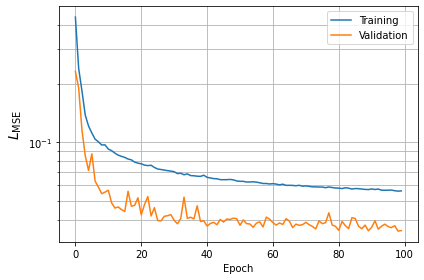

Text(0, 0.5, 'Accuracy')

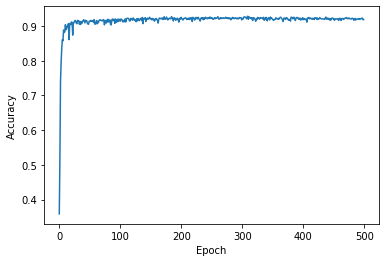

In [ ]:
# Plot training & validation loss values
plt.semilogy(history.history['loss'][:100])
plt.plot(history.history['val_loss'][:100])
plt.ylabel('$L_\mathrm{MSE}$', fontsize=14)
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.grid(which='both')
plt.tight_layout()
plt.savefig('loss_small.pdf')
plt.show()

plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.savefig(PLOT_DIR + 'accuracy.svg')

## Calibration Function Evaluation

In [ ]:
x = np.linspace(0, 70, 1000)
idx = np.random.randint(0, len(y_train))
# x_train, y_train = next(eval_gen)
plt.plot(x, energyToToTSimple(x, *(y_train[idx]*p_norm)))
plt.plot(x, energyToToTSimple(x, *(regressor.predict(x_train)[idx]*p_norm)))

## Parameter MC Agreement

### Training data

1.0161488739244202 1.0175406539373755 0.0542961202306973 0.042082905151272804
1.011136427982748 1.0096144519867492 0.04720704525687969 0.03689494354186589
1.0477537251901752 1.0444107874202826 0.11977432557720864 0.1013640070739797
1.0156274387262567 1.0155663571537537 0.1152869314499208 0.09482061964523734


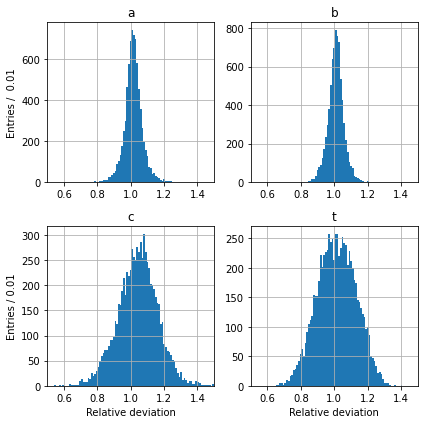

In [ ]:
def expFit(x, lam):
    return lam * np.exp(-lam * x)

fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=False, sharey=False)
ax = ax.flatten()
titles=['a', 'b', 'c', 't']
bins = np.linspace(0.5, 1.5, 100)
for idx in range(4):
    v = (y_eval / np.nan_to_num(regressor.predict([x_eval, np.zeros((len(x_eval), 2))])))[:,idx]
    # v = np.abs(v - np.median(v))
    v[np.abs(v - np.median(v)) > 10] = 0
    # ax[idx].set_yscale('log')
    h, b, s = ax[idx].hist(v, bins=bins, density=False)
    # popt, pcov = scipy.optimize.curve_fit(expFit, b[:-1], h)
    # print(popt)
    # ax[idx].plot(b[:-1], expFit(b[:-1], *popt), ls='--', color='k')

    ax[idx].set_title(titles[idx])
    ax[idx].set_xlim(.5, 1.5)
    ax[idx].grid()
    print(np.median(v), np.mean(v), np.std(v), np.mean(np.abs(v - 1)))

# axis labels
ax[2].set_xlabel('Relative deviation')
ax[0].set_ylabel('Entries /  %.2f' % np.diff(bins)[0])
ax[3].set_xlabel('Relative deviation')
ax[2].set_ylabel('Entries / %.2f' % np.diff(bins)[0])
plt.tight_layout()
plt.savefig('dnn_calib_params.pdf')

In [ ]:
v = np.nan_to_num(regressor.predict([x_eval, np.zeros((len(x_eval), 2))]))

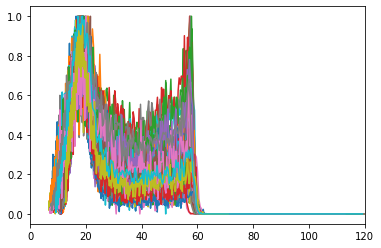

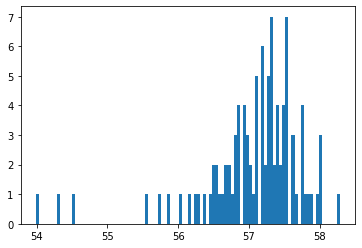

In [ ]:
p_pred = []
bins = np.arange(400)
for idx in range(100):
    a, b, c, t = v[idx] * p_norm
    peak = peaksEval[idx]
    peak_energy = ToTtoEnergySimple(peak, a, b, c, t)
    p_pred.append( peak_energy[1] )

    bins_ = ToTtoEnergySimple(bins, a, b, c, t)
    plt.plot(bins_, x_eval[idx])
plt.xlim(0, 120)
plt.show()

plt.hist(p_pred, bins=100);

In [ ]:
peaksEval.shape

(7675, 2)

In [ ]:
peak = peaksEval
ToTtoEnergySimple(peak1, a, b, c, t)

## Evaluation data

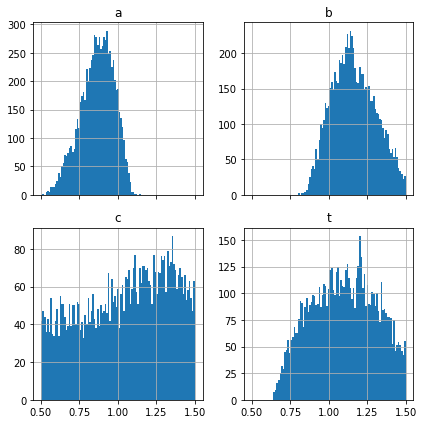

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=False)
ax = ax.flatten()
titles=['a', 'b', 'c', 't']
bins = np.linspace(0.5, 1.5, 100)
for idx in range(4):
    ax[idx].hist((y_eval / regressor.predict([x_eval, np.zeros((len(x_eval), 2))]))[:,idx], bins=bins)
    ax[idx].set_title(titles[idx])
    ax[idx].grid()
plt.tight_layout()

## Training Evaluation

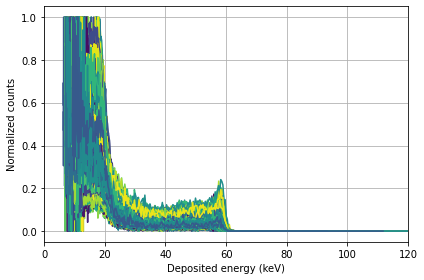

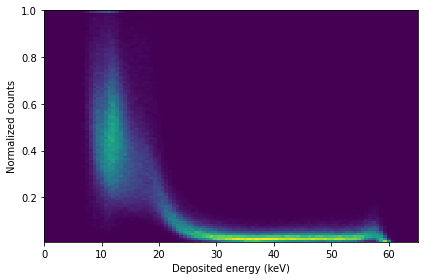

In [ ]:
# x_eval = next(eval_gen)[0]
p_predict = regressor.predict([x_eval, np.asarray(peaksEval)])
x = np.arange(400)
p = p_predict * p_norm

N = 1024
color = [getColor('viridis', N, idx) for idx in range(N)]
np.random.shuffle(color)

x_total, y_total = [], []
for idx in range(N):
    x_ = ToTtoEnergySimple(x, *p[idx])
    y_ = x_eval[idx].flatten()[:-1] / np.diff(x_)

    x_total.append(x_[:-1]), y_total.append(y_ / np.max(y_))
    plt.plot(x_[:-1], y_ / np.max(y_), color=color[idx])
plt.xlim(0, 120)
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalized counts')
plt.grid()
plt.tight_layout()
plt.savefig('spectra_eval_small.pdf')
plt.show()

# Density plot
plt.hist2d(np.asarray(x_total).flatten(), np.asarray(y_total).flatten(), bins=(np.linspace(0, 65, 100), np.linspace(0.01, 1., 100)));
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Normalized counts')
plt.tight_layout()
plt.savefig('spectra_eval_hist_small.pdf')
plt.show()

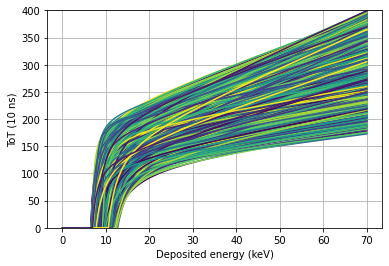

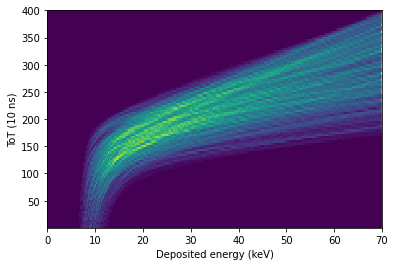

In [ ]:
x = np.linspace(0, 70, 1000)
# p_predict = regressor.predict(x_eval)
p = p_predict * p_norm

x_total, y_total = [], []
for idx in range(N):
    y = energyToToTSimple(x, *p[idx])
    x_total.append(x), y_total.append(y)
    plt.plot(x, y, color=color[idx])
plt.ylim(0, 400)
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.grid()
plt.show()

# Density plot
plt.hist2d(np.asarray(x_total).flatten(), np.asarray(y_total).flatten(), bins=(x, np.linspace(0.1, 400, 100)));
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.show()

## Measurement Evaluation

In [ ]:
def predictMeasurement(measurement):
    import scipy.interpolate
    p_predict = regressor.predict([measurement, np.zeros((len(measurement), 2))])
    p = p_predict * p_norm
    x = np.arange(400)

    color = [getColor('viridis', 256, idx) for idx in range(256)]
    np.random.shuffle(color)

    x_new = np.linspace(0, 80, 3000)
    y_total = np.zeros(len(x_new))
    THL = getTHL(*p.T)
    for idx in range(256):
        if not idx % 16 in [0, 1, 14, 15]:
            continue

        x_ = ToTtoEnergySimple(x, *p[idx])
        f = scipy.interpolate.interp1d(x_[:-1], 
                  measurement[idx].flatten()[:-1] / np.diff(x_), bounds_error=False, fill_value=0)
        y = f(x_new) 
        y_total += np.nan_to_num(y / np.max(y))
        # plt.plot(ToTtoEnergySimple(x, *p[idx]), measurement[idx].flatten())
        plt.plot(x_new, y / np.max(y), color=color[idx])

    plt.xlim(0, 75)
    plt.grid()
    plt.xlabel('Deposited energy (keV)')
    plt.ylabel('Normalized counts')
    plt.tight_layout()
    plt.savefig('DNNCalib_output.pdf')
    plt.show()

    # THL distribution
    h, b, p_ = plt.hist(THL, bins=30)
    plt.axvline(x=np.mean(THL), color='k')
    plt.axvline(x=np.median(THL), ls='-.', color='k')
    plt.axvline(x=np.mean(THL) + np.std(THL), ls='--', color='k')
    plt.axvline(x=np.mean(THL) - np.std(THL), ls='--', color='k')
    plt.xlabel(r'Threshold energy $E_\mathrm{THL}$ (keV)')
    plt.ylabel('Number of pixels / %.2f keV' % np.diff(b)[0])
    plt.grid()
    plt.tight_layout()
    plt.savefig('DNNCalib_THL_hist.pdf')
    plt.show()

    # Sum over all large pixels 
    plt.xlim(0, 75)
    plt.plot(x_new, y_total / np.max(y_total))
    plt.grid()
    plt.xlabel('Deposited energy (keV)')
    plt.ylabel('Normalized counts')
    plt.tight_layout()
    plt.savefig('DNNCalib_mean_hist.pdf')
    plt.show()

    return y_total / np.max(y_total), p, np.median( THL )

def plotMeasurementPrediction(thl_range, mean_thl_list, std_thl_list, y_total_list, p_mean_list, name='THLshift'):
    plt.errorbar(thl_range, mean_thl_list, yerr=std_thl_list, marker='x', capsize=5)
    plt.grid()
    plt.xlabel('THL shift (DAC)')
    plt.ylabel(r'Threshold energy $E_\mathrm{THL}$ (keV)')
    plt.tight_layout()
    plt.savefig('DNNCalib_%s_energy.pdf' % name)
    plt.show()

    fig, ax = plt.subplots()
    axCBar = fig.add_axes([.92, 0.1, 0.05, 0.8])

    for idx, y_total in enumerate(y_total_list):
        color = getColor('viridis', len(y_total_list), idx)
        ax.plot(np.linspace(0, 80, 3000), y_total, color=color)
    getColorBar(axCBar, cbMin=thl_range[0], cbMax=thl_range[-1], N=len(thl_range), 
                   label='%s (DAC)' % name, rotation=0, use_float=False)

    ax.set_xlim(0, 65)
    ax.grid()
    ax.set_xlabel('Deposited energy (keV)')
    ax.set_ylabel('Normalized counts')
    fig.savefig('DNNCalib_%s_hist.pdf' % name, bbox_inches='tight')
    plt.show()

    x = np.linspace(0, 70, 1000)
    fig, ax = plt.subplots()
    axCBar = fig.add_axes([.92, 0.1, 0.05, 0.8])

    for idx, p in enumerate(p_mean_list):
        color = getColor('viridis', len(y_total_list), idx)
        ax.plot(x, energyToToTSimple(x, *p), color=color)
    getColorBar(axCBar, cbMin=thl_range[0], cbMax=thl_range[-1], N=len(thl_range), 
                   label='%s (DAC)' % name, rotation=0, use_float=False)

    ax.grid()
    ax.set_xlabel('Deposited energy (keV)')
    ax.set_ylabel('ToT (10 ns)')
    fig.savefig('DNNCalib_%s_calib_curves.pdf' % name, bbox_inches='tight')
    plt.show()

def getColorBar(ax, cbMin, cbMax, N=20, label=None, rotation=90, use_float=False):
    # Plot colorbar
    import matplotlib as mpl
    from matplotlib.colors import ListedColormap
    cmap = mpl.cm.get_cmap('viridis', N)
    norm = mpl.colors.Normalize(vmin=cbMin, vmax=cbMax)
    cBar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')

    # cBar.ax.invert_yaxis()
    cBar.formatter.set_powerlimits((0, 0))
    cBar.ax.yaxis.set_offset_position('right')
    cBar.update_ticks()

    labels = np.linspace(cbMin, cbMax, N + 1)
    locLabels = np.linspace(cbMin, cbMax, N)
    loc = labels + abs(labels[1] - labels[0])*.5
    cBar.set_ticks(loc)
    if use_float:
        cBar.ax.set_yticklabels(['%.1f' % loc for loc in locLabels], rotation=rotation, verticalalignment='center')
    else:
        cBar.ax.set_yticklabels(['%d' % loc for loc in locLabels], rotation=rotation, verticalalignment='center')
    cBar.outline.set_visible(False)
    cBar.set_label(label)

### Calibration Measurements

In [ ]:
directory

'/content/gdrive/My Drive/Colab Notebooks/calib_data/'

In [ ]:
measurement.keys()

dict_keys(['Test1'])

In [ ]:
# Is data already binned?
make_hist = False
Ikrum = 30 # 11
# measurement = np.nan_to_num( json.load(open(directory + 'measurements/ToTMeasurement_109_6_22_Ikrum%d.json' % Ikrum, 'rb')) )
# measurement = np.nan_to_num( json.load(open(directory + 'measurements/params_%s_Ikrum%d_hist.json' % ('prag', Ikrum), 'rb') ) )
measurement = np.nan_to_num( json.load(open('/content/gdrive/My Drive/share/DNNCalib/measurements/KalibRaumTem22.json', 'rb') ) )['Test1']
histDict = {}
for slot in measurement.keys():
    if slot == 'bins':
        continue
    print(slot)
    hist = []
    for pixel in range(256):
        if make_hist:
            h, b = np.histogram(np.asarray(measurement[slot]).T[pixel], bins=np.arange(1, 402))
        else:
            h = np.asarray( measurement[slot][pixel] )
            b = np.arange(len(h))

        h = np.asarray(h, dtype=float)
        h /= float(np.max(h))
        hist.append( np.nan_to_num(h) )
    histDict[int(slot[-1])] = hist

1


In [ ]:
import scipy.signal
measurements = [np.nan_to_num( json.load(open('/content/gdrive/My Drive/share/DNNCalib/measurements/KalibRaumTem22.json', 'rb') ) )['Test1']]

meas_dict = {}
for m_idx, measurement in enumerate(measurements):
    histDict = {}
    for slot in measurement.keys():
        if slot == 'bins':
            continue
        print(slot)
        hist = []
        for pixel in range(256):
            h = np.asarray( measurement[slot][pixel] )
            b = np.arange(len(h))

            h = np.asarray(h, dtype=float)
            h /= float(np.max(h))
            hist.append( np.nan_to_num(h, 15, 3) )
        histDict[int(slot[-1])] = hist
    meas_dict[0] = histDict

1


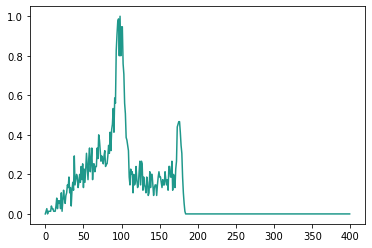

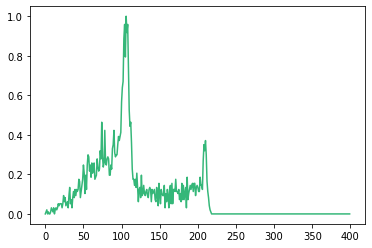

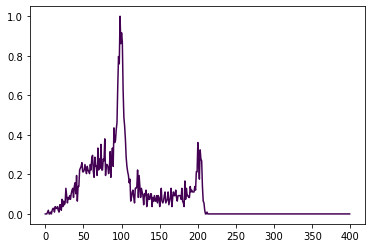

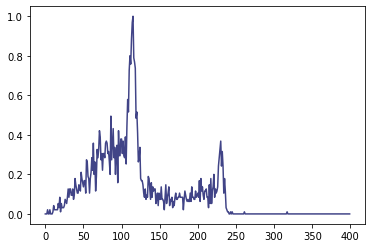

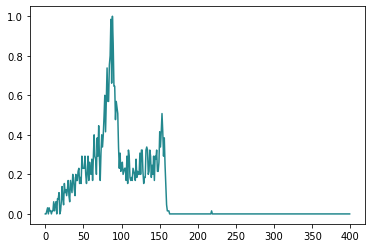

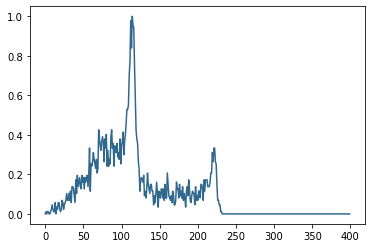

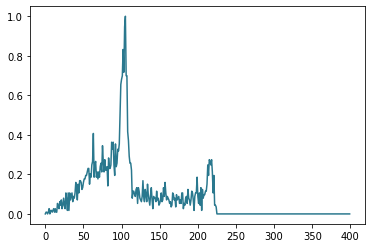

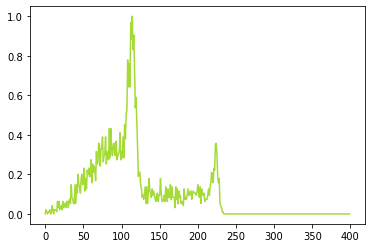

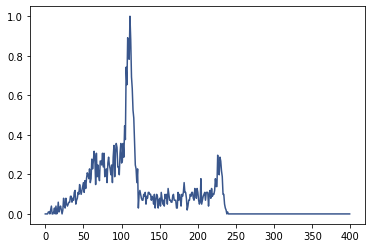

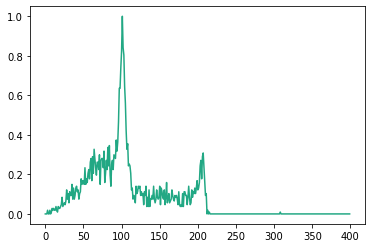

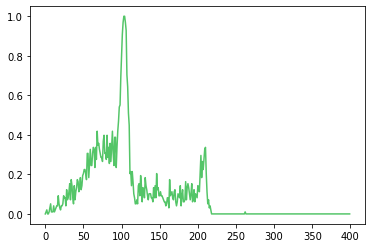

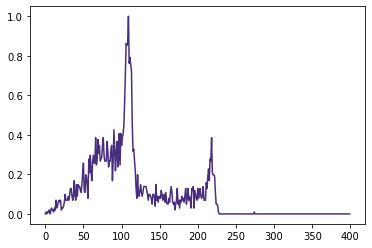

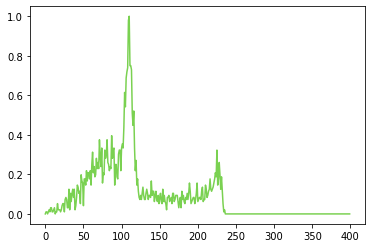

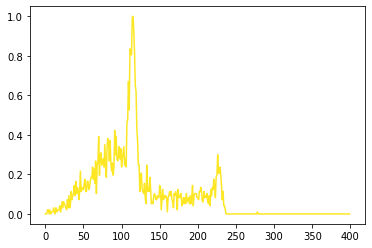

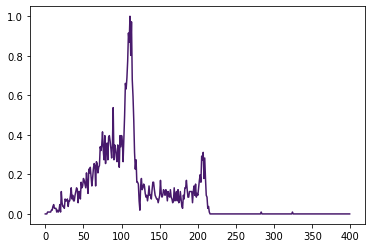

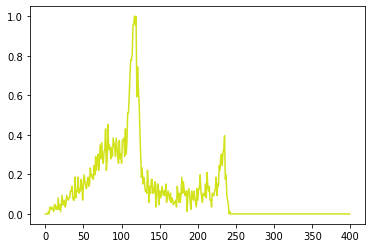

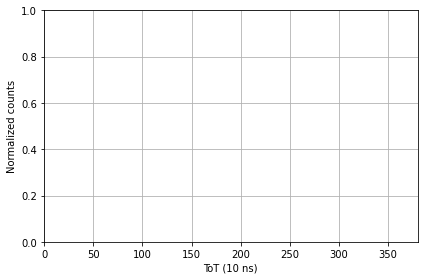

In [ ]:
color = getColor('viridis', 16, np.arange(16))
np.random.shuffle(color)

pixel_idx = 0
for pixel in range(4 * 16):
    if not pixel % 16 in [0, 1, 14, 15]:
        continue
    plt.plot(np.asarray(histDict[1])[pixel], color=color[pixel_idx])
    pixel_idx += 1
    plt.show()

plt.ylabel('Normalized counts')
plt.xlabel('ToT (10 ns)')
plt.xlim(0, 380)
plt.grid()
plt.tight_layout()
plt.savefig('DNNCalib_input_small.pdf')

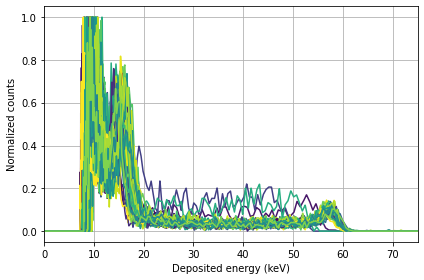

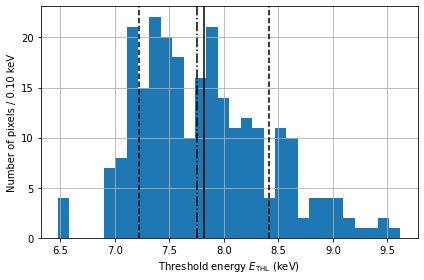

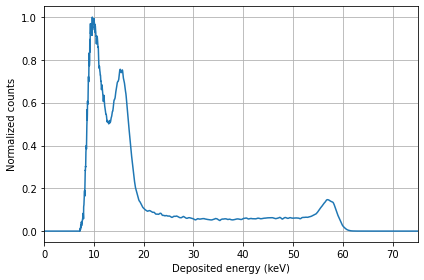

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

paramsDict = {}
for key in [1]: # histDict.keys()):
    m = histDict[key]
    m = np.asarray(m).reshape((len(m), -1, 1))
    paramsDict[key] = regressor.predict([m, np.zeros((len(m), 2))]) * p_norm
    predictMeasurement(m)

    a, b, c, t = paramsDict[key].T
    outDict = {pixel: {'a': a[pixel], 'b': b[pixel], 'c': c[pixel], 't': t[pixel]} for pixel in range(256)}
    # with open(directory + 'measurements/params_%d_Ikrum%d.json' % (titles[int(key) - 1], Ikrum), 'w') as f:
    #      json.dump(outDict, f, cls=NumpyEncoder)

In [ ]:
regressor.predict([m, np.zeros((len(m), 2))])

array([[0.68079096, 0.6112652 , 0.3527542 , 0.71343696],
       [0.86529404, 0.6686461 , 0.38756394, 0.7788305 ],
       [0.915417  , 0.7883438 , 0.35399473, 0.8264196 ],
       ...,
       [0.6766463 , 0.79876375, 0.28580377, 0.7253792 ],
       [0.9017549 , 0.69609594, 0.39774942, 0.8005836 ],
       [0.8485665 , 0.6746986 , 0.3815223 , 0.7677418 ]], dtype=float32)

In [ ]:
outDict[0]

{'a': 0.6400550365447999,
 'b': 69.86403465270996,
 'c': -221.47854566574097,
 't': 6.148248910903931}

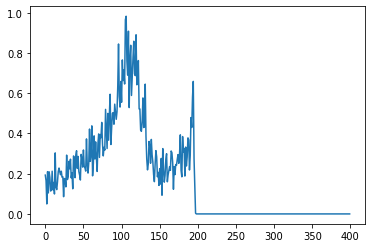

In [ ]:
x = x_eval[30].flatten()
x_n = np.random.normal(x, 0.02)
x_n[x == 0] = 0
x_n[x_n < 0] = 0
plt.plot(x_n)

### THL Variation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


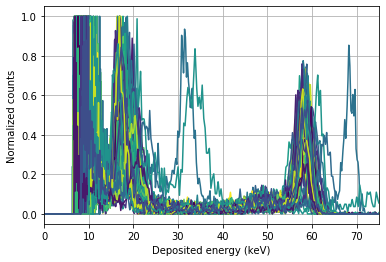

7.598627105312435


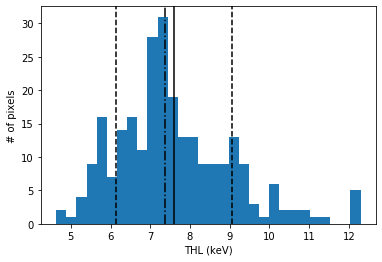

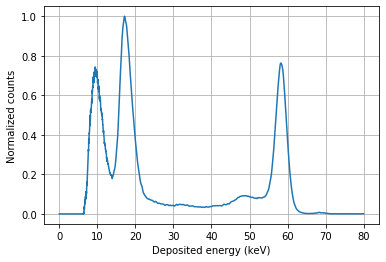

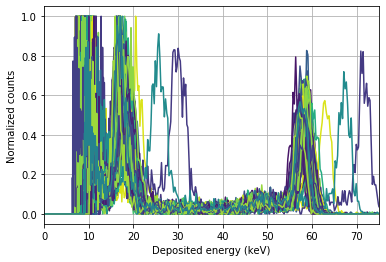

8.135545691459132


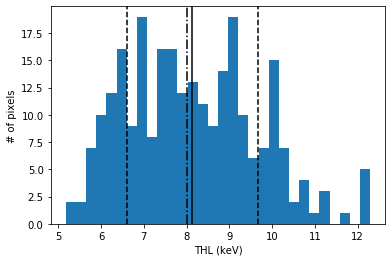

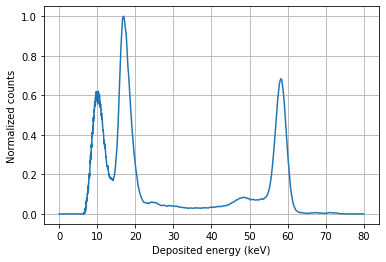

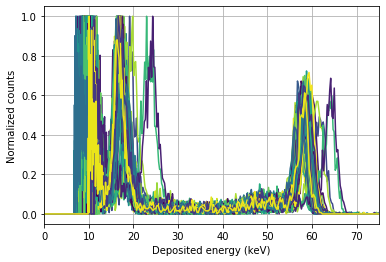

8.61730369548603


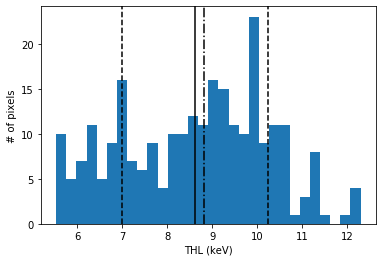

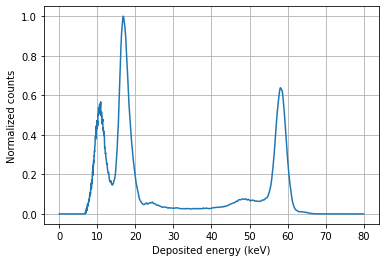

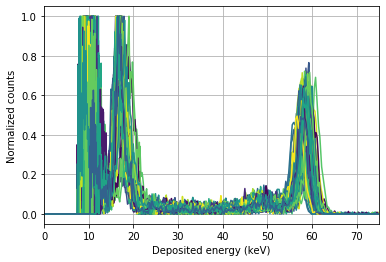

9.082636530163505


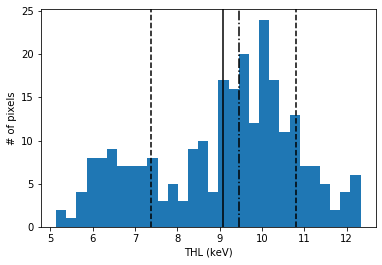

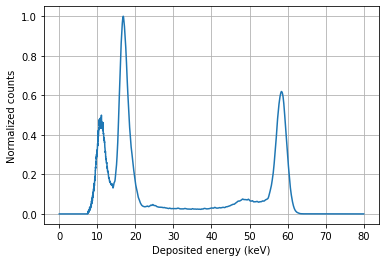

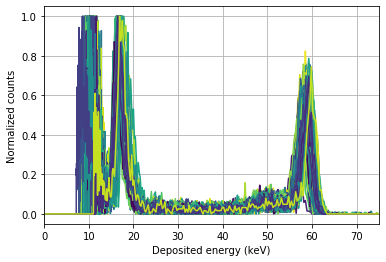

9.48384438296209


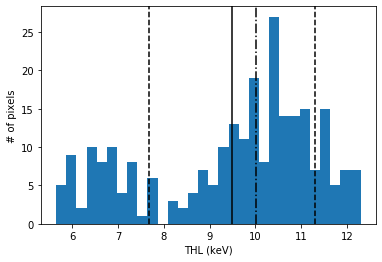

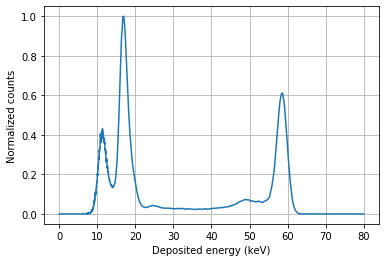

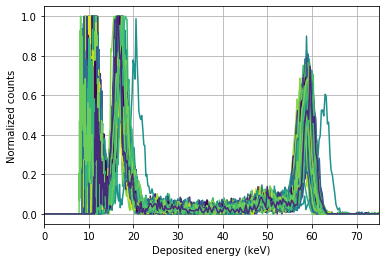

9.932090204718506


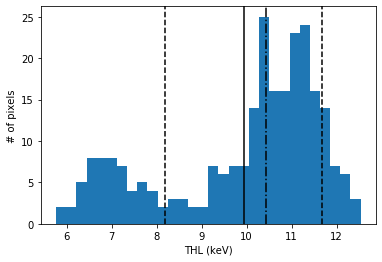

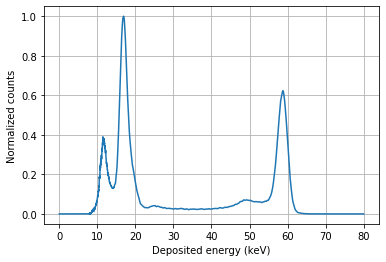

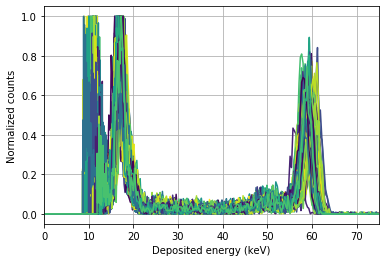

10.351280207924564


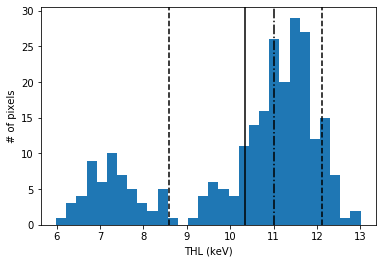

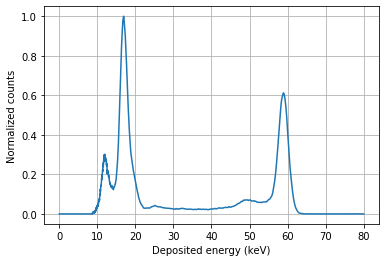

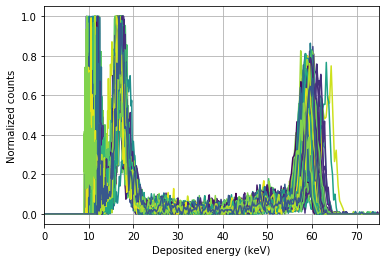

10.842571717894703


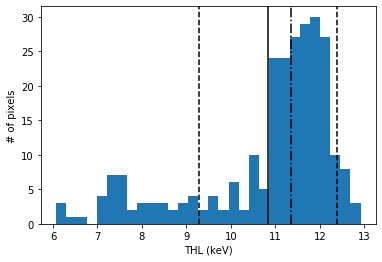

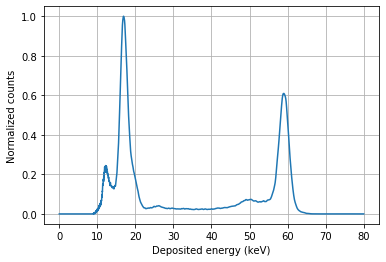

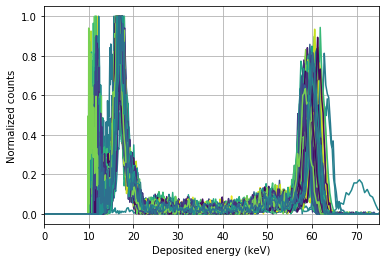

11.122430058885552


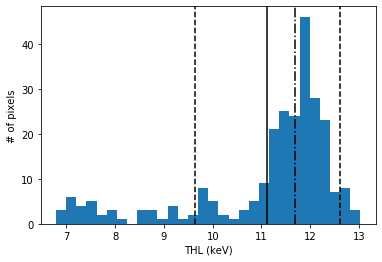

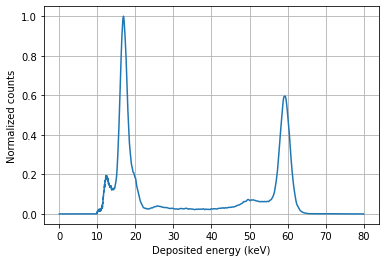

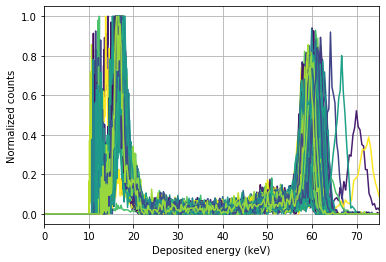

11.346517291130727


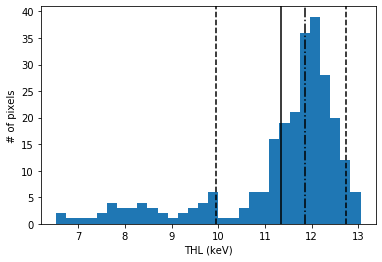

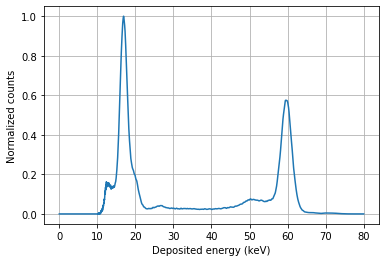

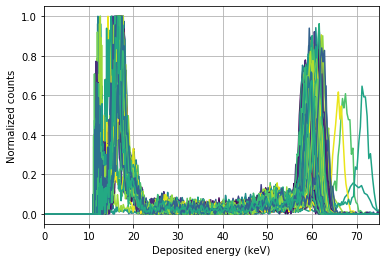

11.532542145672387


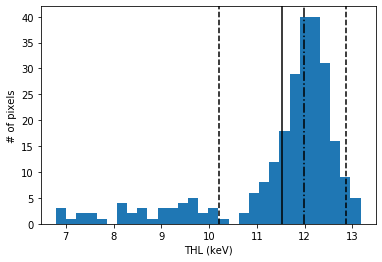

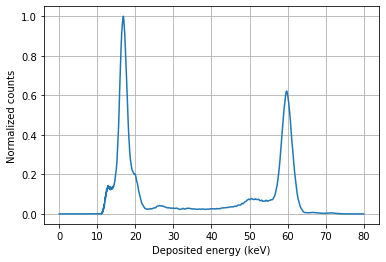

In [ ]:
y_total_list, median_thl_list = [], []
p_mean_list = []
thl_range = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for thl in thl_range:
    measurement = np.nan_to_num( json.load(open(directory + 'AmTHL/ToTMeasurement_AmTHL%d.json' % thl                                                                                                                                , 'rb')) )
    measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
    measurement = measurement.reshape((len(measurement), -1, 1))

    y_total, p, median_thl = predictMeasurement(measurement)
    p_mean_list.append( np.mean(p, axis=0) )
    y_total_list.append( y_total )
    median_thl_list.append( median_thl )

a 2.655652101384476 3.1938103411812335
b 6.57143668376375 10.516259629861452
c -73.58537911903113 -44.03933379217051
t -1.7413061456754804 -1.6188180024619214


Text(0, 0.5, 'Change')

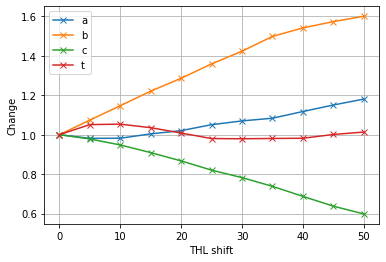

In [ ]:
for idx in range(4):
    y = np.asarray(p_mean_list).T[idx]
    print(titles[idx], min(y), max(y))
    plt.plot(thl_range, y / y[0], marker='x', label=titles[idx])
plt.legend()
plt.grid()
plt.xlabel("THL shift")
plt.ylabel('Change')

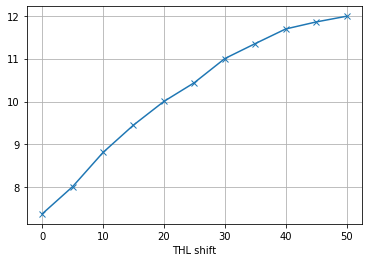

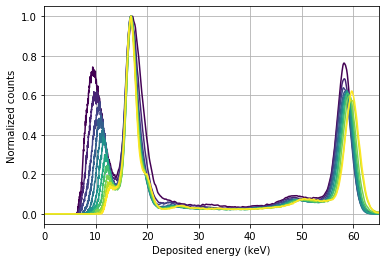

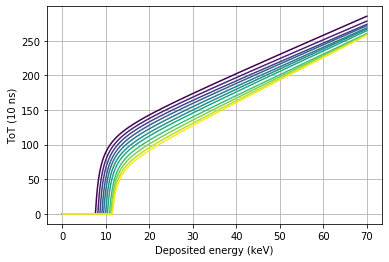

In [ ]:
plotMeasurementPrediction(thl_range, median_thl_list, y_total_list, p_mean_list)

### Ikrum Variation

In [ ]:
y_total_list, median_thl_list = [], []
p_mean_list = []
Ikrum_range = [10, 15, 20, 25, 30, 35, 40, 45, 50]
for Ikrum in Ikrum_range:
    measurement = np.nan_to_num( json.load(open(directory + 'AmIkrum/ToTMeasurement_AmIkrum%d.json' % Ikrum                                                                                                                                , 'rb')) )
    measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
    measurement = measurement.reshape((len(measurement), -1, 1))

    y_total, p, median_thl = predictMeasurement(measurement)
    p_mean_list.append( np.mean(p, axis=0) )
    y_total_list.append( y_total )
    median_thl_list.append( median_thl )

In [ ]:
for idx in range(4):
    y = np.asarray(p_mean_list).T[idx]
    print(titles[idx], min(y), max(y))
    plt.plot(Ikrum_range, y / y[0], marker='x', label=titles[idx])
plt.legend()
plt.grid()
plt.xlabel("THL shift")
plt.ylabel('Change')

In [ ]:
plotMeasurementPrediction(Ikrum_range, median_thl_list, y_total_list, p_mean_list)

### Single Calibration Curves

In [ ]:
measurement = np.nan_to_num( json.load(open(directory + 'AmIkrum/ToTMeasurement_AmIkrum20.json', 'rb')) )
measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
measurement = np.asarray(measurement).reshape((len(measurement), -1, 1))

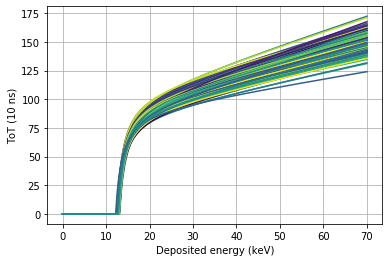

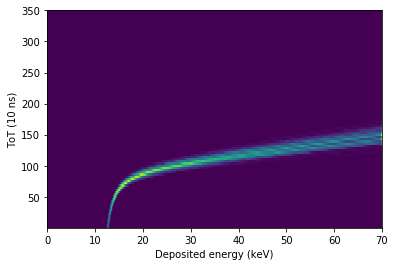

[  0.95520215  11.32999867 -60.38557494  -2.22425623]


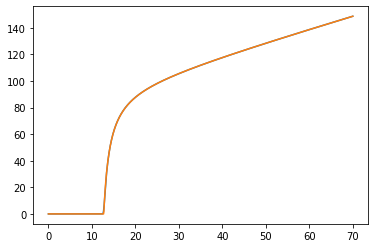

In [ ]:
x = np.linspace(0, 70, 1000)
p_predict = regressor.predict(measurement)
p = p_predict * p_norm

x_total, y_total = [], []
color = [getColor('viridis', 256, idx) for idx in range(256)]
np.random.shuffle(color)
for idx in range(256):
    if idx % 16 in [0, 1, 14, 15]:
        continue
    y = energyToToTSimple(x, *p[idx])
    plt.plot(x, y, color=color[idx])
    x_total.append( x ), y_total.append( y )
plt.grid()
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.show()

# Density plot
plt.hist2d(np.asarray(x_total).flatten(), np.asarray(y_total).flatten(), bins=(x, np.linspace(0.1, 350, 100)));
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT (10 ns)')
plt.show()

# Mean curve
plt.plot(x, np.mean(y_total, axis=0))
import scipy.optimize
p0 = [2.64001481, 4.75595151, -79.80103223, -4.12532132]
popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, np.mean(y_total, axis=0), p0=p0)
plt.plot(x, energyToToTSimple(x, *popt))
print(popt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


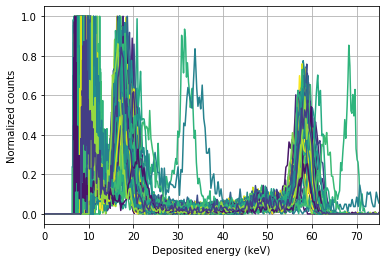

7.598627105312435


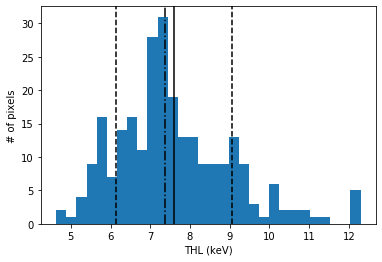

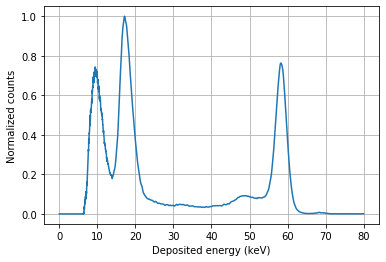

(array([0.        , 0.        , 0.        , ..., 0.00064853, 0.00065342,
        0.0006583 ]),
 array([[  2.49669209,   4.83251229, -68.07475805,  -1.41861339],
        [  1.68307349,   5.09832424, -73.44749093,  -1.6250495 ],
        [  2.60608077,   6.19630015, -77.07552314,  -1.7306475 ],
        ...,
        [  2.90874422,   6.93371594, -68.15984845,  -1.98064113],
        [  1.20094091,   5.54536366, -75.88785052,  -1.75880152],
        [  1.09896258,   5.31161034, -69.93821025,  -1.78081617]]),
 7.3805459820121655)

In [ ]:
measurement = np.nan_to_num( json.load(open(directory + 'AmTHL/ToTMeasurement_AmTHL%d.json' % 0                                                                                                                                , 'rb')) )
measurement = np.asarray( [m / np.max(m) for m in np.asarray(measurement)] )
measurement = measurement.reshape((len(measurement), -1, 1))

predictMeasurement(measurement)